In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
# from BfTableGenerator import RansacCollector
from BfTableGenerator import TDmapLoader
from tqdm import tqdm
# from open3d import JVisualizer 
from Utils import *
from DDBSCAN import Raster_DBSCAN
import open3d as op3
# op3.visualization.webrtc_server.enable_webrtc()
from open3d.web_visualizer import draw
from VisulizerTools import *
from tqdm import tqdm_notebook
import time
from sklearn.cluster import DBSCAN
# +80
from p_tqdm import p_map
from joblib import Parallel, delayed

def get_pcd_colored_dir(Td_map,Colored_map):

    Xs = []
    Ys = []
    Zs = []
    Labels = []
    for i in range(Td_map.shape[0]):
        longitudes = theta[i]*np.pi / 180
        latitudes = azimuths * np.pi / 180 
        hypotenuses = Td_map[i] * np.cos(longitudes)
        X = hypotenuses * np.sin(latitudes)
        Y = hypotenuses * np.cos(latitudes)
        Z = Td_map[i] * np.sin(longitudes)
        Valid_ind = (Td_map[i] != 0)
        Xs.append(X[Valid_ind])
        Ys.append(Y[Valid_ind])
        Zs.append(Z[Valid_ind])
        Labels.append(Colored_map[i][Valid_ind])

    Xs = np.concatenate(Xs)
    Ys = np.concatenate(Ys)
    Zs = np.concatenate(Zs)
    Labels = np.concatenate(Labels)
    XYZ = np.concatenate([Xs.reshape(-1,1),Ys.reshape(-1,1),Zs.reshape(-1,1)],axis = 1)
    Colors = np.full((len(Labels),3),np.array([[153,153,153]])/256)
    unique_label = np.unique(Labels)
    for l in unique_label[1:]:
        Colors[Labels == l] = color_map[l%len(color_map)]

    pcd = op3.geometry.PointCloud()
    pcd.points = op3.utility.Vector3dVector(XYZ)
    pcd.colors = op3.utility.Vector3dVector(Colors)
    
    return pcd     

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] Resetting default logger to print to terminal.


In [2]:
def get_thred_modified(ts,d ,thred_s ,N ,delta_thred ,step):# Ransac Para
    ts_temp = ts.copy()
    ts_temp[ts_temp == 0] = 1000
    valid_dises = []
    for i in range(N):
        sample = np.random.choice(ts_temp,replace=False)
        set_d = ts_temp[(ts_temp > sample - d)&(ts_temp < sample + d)]
        condition_thred = len(set_d)/len(ts_temp) > thred_s
        if condition_thred :
            valid_dises.append(sample)
            
    if len(valid_dises) == 0:
        return 1000

    cur_thred = np.min(valid_dises)

    while True:
        next_thred = cur_thred - step
        if (len(ts[ts > next_thred])/len(ts) - len(ts[ts > cur_thred])/len(ts)) < delta_thred:
            break
        cur_thred = next_thred

    return next_thred

In [3]:
def get_gen(pcap_path,time,end_frame):
    lidar_reader = TDmapLoader(pcap_path)
    frame_gen = lidar_reader.frame_gen()
    aggregated_map = []
    sampled_ind = np.random.choice(np.arange(17000),size = 2000, replace = False)
    sampeled_num = 0
    for i in tqdm(range(end_frame)):
        Td_map = next(frame_gen)
        if i in sampled_ind:
            aggregated_map.append(Td_map)
            sampeled_num += 1
        if (sampeled_num == 2000) or (Td_map is None):
            break
    return np.array(aggregated_map),time

In [4]:
bck_path = r'D:\LiDAR_Data\MidTown\Larue'
output_path = r'D:\LiDAR_Data\MidTown\Larue'
pcaps_list = os.listdir(bck_path)
pcaps_list = [p for p in pcaps_list if 'pcap' in p.split('.')]
times = [int(pcaps_list[i].split('.')[0].split('-')[-3]) for i in range(len(pcaps_list))]
aggregated_maps_multiple = []
time_ind = np.argsort(times)
results = Parallel(n_jobs=4)(delayed(get_gen)(os.path.join(bck_path,pcaps_list[i]),times[i],18000) for i in tqdm(range(len(pcaps_list))))
aggregated_maps = []
times = []
for r,time in results:
    aggregated_maps.append(r)
    times.append(time)
aggregated_maps = np.array(aggregated_maps)
aggregated_maps = aggregated_maps[np.argsort(times)]

100%|███████████████████████████████████████████████████████████████████████████████| 28/28 [1:09:40<00:00, 149.31s/it]


In [5]:
aggregated_maps = np.concatenate(aggregated_maps)

In [3]:
import time

In [7]:
s = time.time()
time.sleep(20)
time.time() - s

20.013290882110596

In [4]:
aggregated_maps.shape

(56000, 32, 1800)

In [3]:
aggregated_maps = np.load(r'D:\LiDAR_Data\MidTown\Larue\24H_Agg.npy')

In [7]:
np.save(r'D:\LiDAR_Data\MidTown\Larue\24H_Agg.npy',aggregated_maps)


In [8]:
thred_map = np.zeros((32,1800))
for i in tqdm(range(thred_map.shape[0])):
    for j in range(thred_map.shape[1]):
        thred_map[i,j] = get_thred_modified(aggregated_maps[:,i,j],d = 2 ,thred_s = 0.5,N = 20,delta_thred = 1e-3,step = 0.1)

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [36:45<00:00, 68.91s/it]


In [9]:
np.save(r'D:\LiDAR_Data\MidTown\Larue\bck_map.npy',thred_map)

In [6]:
thred_map = np.load(r'D:\LiDAR_Data\MidTown\Lawrence\Calibration\bck_map.npy')
aggregated_maps = np.load(r'D:\LiDAR_Data\MidTown\RoundaboutNW\24H_Agg.npy')

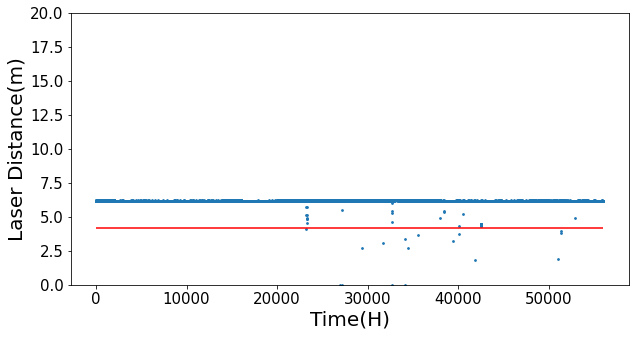

In [9]:
laser_id = theta_raw[0] == theta
azimuth_channel = int(np.around((23523/100)/0.2)) + 10

temp = aggregated_maps[:,laser_id,azimuth_channel]
# thred = get_thred_modified(temp.flatten(),d = 2,thred_s = 0.5,N = 10,delta_thred = 0.001,step = 0.2)
thred = thred_map[laser_id,azimuth_channel]
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(aggregated_maps)),aggregated_maps[:,laser_id,azimuth_channel],s = 3)
plt.hlines(thred,0,len(aggregated_maps),color = 'r')
plt.ylim(0,20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.ylabel('Laser Distance(m)',fontsize = 20)
plt.xlabel('Time(H)',fontsize = 20)
plt.show()

In [15]:
clustering_td = Raster_DBSCAN(window_size=(5,13),eps = 1.5, min_samples= 12, Td_map_szie=thred_map.shape)   
Td_map = aggregated_maps[1500]
Foreground_map = (Td_map < thred_map)&(Td_map != 0)
Labeling_map = clustering_td.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)
Background_map = (Td_map >= thred_map)&(Td_map != 0)
# pcd = get_pcd_colored_filtered(Td_map,Labeling_map,Foreground_map)
pcd = get_pcd_colored(Td_map,Labeling_map)
draw(pcd,height=1000,width=1000)

WebVisualizer(window_uid='window_4')

In [13]:
pcd = get_pcd_colored_dir(thred_map,np.full(thred_map.shape,True))
draw(pcd,height=1000,width=1000)

WebVisualizer(window_uid='window_3')

In [5]:
Td_map = aggregated_maps[0]
Colored_map = np.full(Td_map.shape,0)
# laser_id = theta_raw[20] == theta
azimuth_channel = int(np.around((24903/100)/0.2)) + 10
Colored_map[:,azimuth_channel] = 1
pcd = get_pcd_colored_dir(Td_map,Colored_map)
draw(pcd)


WebVisualizer(window_uid='window_0')

# PLANE MODEL

In [6]:
plane_model, inliers = pcd.segment_plane(distance_threshold=0.2,
                                         ransac_n=3,
                                         num_iterations=1000)
inlier_cloud = pcd.select_by_index(inliers)
outlier_cloud = pcd.select_by_index(inliers, invert=True)

In [7]:
np.save(r'D:\LiDAR_Data\MidTown\Larue\plane_model.npy',plane_model)